In [1]:
"""
Import necessary libraries
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv


In [2]:
"""
Read in the data
"""
opportunities = pd.read_pickle('opportunities.p')
NAICS = pd.read_pickle('NAICS.p')

# Exploratory Data Analysis

## *Data Cleaning and Feature Engineering*

### Objectives
- Column naming convention
- NAICS categories must be joined with opportunities.
- Record creation date should be subtracted from system close date to create a new feature representing days an opportunity is active.
- The range of estimated revenue for opportunities varies greatly. A feature categorizing estimated revenue by quartile range should be added.
- Remove non-informative data.
- Handle missing data.
- Separate categorical and continuous features for further analysis.

In [3]:
"""dataframe summary"""
opportunities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3894 entries, 0 to 3893
Data columns (total 66 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   (Do Not Modify) Opportunity                                  3894 non-null   object        
 1   Entity ID (Account) (Account)                                3863 non-null   float64       
 2   Address 1: City (Account) (Account)                          3884 non-null   object        
 3   Address 1: State/Province (Account) (Account)                3880 non-null   object        
 4   Address 1: County (Account) (Account)                        3676 non-null   object        
 5   Address 1: Country/Region (Account) (Account)                3884 non-null   object        
 6   Address 1: ZIP/Postal Code (Account) (Account)               3881 non-null   object        
 7   Address 1: Lati

*Rename columns for ease of use and readability*

In [4]:
"""use combination of regular expressions to rename columns"""
opportunities.columns = opportunities.columns.str.replace('\([^)]*\)', '', regex=True)
opportunities.columns = opportunities.columns.str.replace('\.', '', regex=True)
opportunities.columns = opportunities.columns.str.replace(':', '')
opportunities.columns = opportunities.columns.str.replace('/', '_')
opportunities = opportunities.rename(columns=lambda x : x.strip())
opportunities.columns = opportunities.columns.str.replace(' ','_')
opportunities.columns = opportunities.columns.str.replace('Address_1', '')
opportunities.columns = opportunities.columns.str.replace('^_', '', regex=True)
opportunities = opportunities.rename(columns=lambda x : x.strip())

In [5]:
"""rename system system generated GUID to opportunityID"""
opportunities.rename(columns={opportunities.columns[0]: 'opportunity_id', 'Status' : 'Won'},
                     inplace=True)
print(opportunities.columns[0])

opportunity_id


In [6]:
"""prepare NAICS codes for join"""
opportunities['NAICS'] = opportunities['NAICS'].str.replace(r'\D', '', regex=True)
opportunities['NAICS'] = opportunities['NAICS'].str.strip()
opportunities['NAICS'] = opportunities['NAICS'].fillna(value=0)
opportunities['NAICS'].isnull().sum()
opportunities['NAICS'] = opportunities['NAICS'].astype(int)

In [7]:
"""merge opportunities and NAICS"""
opportunities = pd.merge(opportunities, NAICS, how='inner', left_on = ['NAICS'],  right_on = ['mcg_naicscode'])

*Handle Missing and Non-informative Data*

- Drop columns containing non-informative data
- Replace missing values for categorical features with "\_missing_"
- Drop categorical features that take on single value
- Replace missing numerical features with appropriate values or drop if necessary

In [8]:
"""drop additional columns brought in when merging opportunities with NAICS"""
opportunities.drop(columns=['mcg_naicscode','mcg_name', 'mcg_sicdescription',
                            'NAICS', 'mcg_description', 'mcg_subsectortext0'], 
                            axis=1, inplace=True)

In [9]:
"""rename NAICS columns"""
opportunities.rename(columns={'mcg_industry_displayname' : 'industry','mcg_industrysector_displayname' : 'industry_sector'}, inplace=True)

In [10]:
"""verify data type for datetime columns"""
print(opportunities['Created_On'].dtype)
print(opportunities['Est_Close_Date'].dtype)
print(opportunities['System_Close_Date'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


In [11]:
"""create new feature days active"""
opportunities['days_active'] = opportunities['System_Close_Date'] - opportunities['Created_On']
opportunities['days_active'] = opportunities['days_active'] / np.timedelta64(1, 'D')
opportunities['days_active'][opportunities['days_active'] <= 0].count()

858

Creating the new feature "days_active" shows the existence of 858 opportunities that were active for a negative amount of days. This is due to errors with data entry. For the purpose of this analysis all sales opportunities with negative days active will be removed from the data.

In [12]:
"""drop problem dates"""
problem_dates = \
opportunities[['days_active', 'Created_On', 'System_Close_Date']][opportunities['days_active'] < 10].index
opportunities.drop(index=problem_dates, inplace=True)

In [13]:
"""create a new feature "revenue_size" as categorical representation of estimated revenue for a given opportunity"""
pd.set_option('display.float_format', lambda x : '%.2f' % x)
revenue_range = opportunities['Est_Revenue'].describe()
opportunities.loc[opportunities['Est_Revenue'].between(revenue_range['min'], revenue_range['25%'], 'both'), 'revenue_size'] = 'low'
opportunities.loc[opportunities['Est_Revenue'].between(revenue_range['25%'], revenue_range['75%'], 'right'), 'revenue_size'] = 'med'
opportunities.loc[opportunities['Est_Revenue'].between(revenue_range['75%'], revenue_range['max'], 'right'), 'revenue_size'] = 'high'

In [14]:
"""ensure no missing values in key columns"""
opportunities[['opportunity_id', 'Entity_ID']].isna().sum()

opportunity_id    0
Entity_ID         0
dtype: int64

Separate continuous and categorical features

In [15]:
"""separate numerical, categorical, and location related features"""
opportunityID = opportunities[['opportunity_id', 'Entity_ID']].copy()
opp_numeric = opportunities.select_dtypes(include=[np.number])
opp_non_numeric = opportunities.select_dtypes(exclude=[np.number])
opp_non_numeric.drop(columns=['City', 'State_Province', 'Country_Region','County',
                             'ZIP_Postal_Code'], inplace=True)
opp_geographic = opportunities.iloc[:, 0:9].copy()

In [16]:
"""reset indices to unique combination of opportunity_id and Entity_ID"""
opp_numeric = pd.merge(opportunityID, opp_numeric, left_index=True, right_index=True, how='inner')
opp_non_numeric = pd.merge(opportunityID, opp_non_numeric, left_index=True, right_index=True, how='inner')
opp_numeric.drop(columns=['Entity_ID_y', 'Latitude', 'Longitude'], axis=1, inplace=True)
opp_non_numeric.drop(columns=['opportunity_id_y'], axis=1, inplace=True)
opp_numeric.rename(columns={'Entity_ID_x' : 'Entity_ID'}, inplace=True)
opp_non_numeric.rename(columns={'opportunity_id_x' : 'opportunity_id'}, inplace=True)
opp_numeric.set_index(['opportunity_id', 'Entity_ID'], inplace=True)
opp_non_numeric.set_index(['opportunity_id', 'Entity_ID'], inplace=True)
opp_geographic.set_index(['opportunity_id', 'Entity_ID'], inplace=True)

In [17]:
"""fillna for categorical features with value "_missing_" """
opp_non_numeric.fillna(value='_missing_', inplace=True)
opp_non_numeric.isnull().sum().sum()

0

In [18]:
"""
Drop categorical predictors which take on a single value.
They will contribute little to no inforamtion to the final model
"""
variance_threshold = VarianceThreshold(threshold=0.0)
oe = OrdinalEncoder()
opp_non_numeric[opp_non_numeric.columns] = oe.fit_transform(opp_non_numeric)
variance_threshold.fit(opp_non_numeric)
keep_features = [feature for feature in opp_non_numeric.columns
                 if feature in opp_non_numeric.columns[variance_threshold.get_support()]]
opp_non_numeric[opp_non_numeric.columns] = oe.inverse_transform(opp_non_numeric)
opp_non_numeric = opp_non_numeric[keep_features].copy()

In [19]:
"""print null values for continuous features"""
opp_numeric.isnull().sum()

Est_Revenue                  0
No_of_Employees              8
Open_Deals                   0
Open_Revenue                 0
Annual_Revenue               9
Approval_Status           1864
CFY_RSM_Services_Spend     277
Current_Situation         1864
Preferred_Service         1864
Referring_Firm            1864
Revenue_Last_Year         1864
Revenue_This_Year         1864
Territory                 1864
Category                  1864
D&B_Financial             1864
D&B_Ultimate_Parent       1864
Market_Capitalization     1864
Market_Capitalization     1864
PFY_RSM_Services_Spend     277
days_active                  0
dtype: int64

In [20]:
"""
Drop continuous predictors which are missing values for all observations.
They will contribute litle to no inforamtion to the final model and cannot be used with
sklearn data preparation pipeline.
"""
# set threshold: features must contain at least perc * num_records values != pd.nan
perc = 0.001
threshold = int(perc*opportunities.shape[0])
opp_numeric.dropna(axis=1, thresh=threshold, inplace=True)
opp_numeric.isnull().sum()

Est_Revenue                 0
No_of_Employees             8
Open_Deals                  0
Open_Revenue                0
Annual_Revenue              9
CFY_RSM_Services_Spend    277
PFY_RSM_Services_Spend    277
days_active                 0
dtype: int64

Printing a count of null values for each continuous variable shows that the columns "CFY_RSM_Services_Spend" and "PFY_RSM_Services_Spend" are both missing 277 observations each. It's assumed that missing values in these columns represent clients who have not purchased consulting services from the firm in either of the two periods. As such, missing values will be replaced with 0. No_of_Employees and Annual_Revenue are missing 8 and 9 values respectively. Null values for these features will be filled with 0.

In [21]:
"""fill na values in opp_numeric"""
opp_numeric['CFY_RSM_Services_Spend'] = opp_numeric['CFY_RSM_Services_Spend'].fillna(value=0)
opp_numeric['PFY_RSM_Services_Spend'] = opp_numeric['PFY_RSM_Services_Spend'].fillna(value=0)
opp_numeric[['No_of_Employees', 'Annual_Revenue']] = \
            opp_numeric[['No_of_Employees', 'Annual_Revenue']].fillna(value=0)
opp_numeric.isnull().sum()

Est_Revenue               0
No_of_Employees           0
Open_Deals                0
Open_Revenue              0
Annual_Revenue            0
CFY_RSM_Services_Spend    0
PFY_RSM_Services_Spend    0
days_active               0
dtype: int64

In [22]:
"""print dimensions"""
opp_numeric.shape

(1864, 8)

## *Explore Categorical Features*

Objectives
- Examine frequency distribution of categorical features
- visualize categorical features

In [23]:
"""Transform "Status" to binary outcome"""
opp_non_numeric['Won'] = opp_non_numeric['Won'].apply(lambda x : 1 if (x == 'Won') else 0)

In [24]:
"""Print win/loss percentage"""
opp_non_numeric.value_counts('Won',normalize=True)

Won
0   0.52
1   0.48
dtype: float64

In [25]:
"""Win vs Loss by revenue_size and industry"""
opp_non_numeric[['Won', 'revenue_size', 'industry']].groupby(['revenue_size', 'industry']).value_counts('Won', normalize=True)

revenue_size  industry                            Won
high          Business and Professional Services  0     0.75
                                                  1     0.25
              Consumer Products                   0     0.64
                                                  1     0.36
              Financial Services                  0     0.67
                                                        ... 
med           Real Estate                         1     0.43
              State and Local Government          1     0.76
                                                  0     0.24
              TMT                                 0     0.72
                                                  1     0.28
Length: 68, dtype: float64

In [26]:
opp_non_numeric.value_counts('Type', normalize=True)

Type
Existing Relationship - New Business   0.45
Existing Relationship - Renewal        0.28
New Relationship - New Business        0.27
dtype: float64

In [27]:
opp_non_numeric.value_counts('Client_Status', normalize=True)

Client_Status
Existing Client   0.69
_missing_         0.17
New               0.15
dtype: float64

The features "Type" and "Client_Status" provide similar infomation about a given opportunity. Type is a more informative and more complete feature. Client_Status will be dropped.

In [28]:
"""drop Client_Status"""
opp_non_numeric.drop(columns=['Client_Status'], inplace=True)

In [29]:
opp_non_numeric.value_counts('Lead_Source')

Lead_Source
Inactive - Junction Solutions         393
BD Activity                           301
Partner                               269
Director                              197
Referral - Other                      190
Inside Sales                          112
Manager                               103
Referral - Microsoft                   78
Marketing Campaign - National          62
Website                                51
Other                                  29
National Call Center                   27
RSM System Selection                   27
Reputation                              9
COI                                     4
RFP                                     4
Marketing Campaign - Regional           3
RSM Alumni                              2
RSM Int'l Inbound                       1
Inactive - Explore Consulting, LLC      1
Trade Show                              1
dtype: int64

In [30]:
"""plot a count of win/loss by pursuit type"""
# instantiate ploty express figure
fig = px.histogram(opp_non_numeric, x='Won', color='Type', barmode='group')
# update aesthetics
fig.update_layout(title_text='Won/Lost Opportunities by Type', title_x=0.5)

In [31]:
"""create a treemap to cluster wins by industry and industry_sector"""
fig = px.treemap(opp_non_numeric, path=[px.Constant('all'), 'industry', 'industry_sector'], 
                 values = 'Won', title='Wins by Industry Sector')
fig.update_layout(title_x=0.5, margin = dict(t=35, l=25, r=25, b=25))
fig.show()

### Methods

- Print Summary Statistics
- Inspect Data Distribution

In [32]:
"""Print summary statistics"""
pd.set_option('display.float_format', lambda x : '%.2f' % x)
opp_numeric.describe()

,Est_Revenue,No_of_Employees,Open_Deals,Open_Revenue,Annual_Revenue,CFY_RSM_Services_Spend,PFY_RSM_Services_Spend,days_active
count,1864.00,1864.00,1864.00,1864.00,1864.00,1864.00,1864.00,1864.00
mean,597278.87,1566.27,0.90,355214.65,410768705.70,481431.32,470588.04,165.83
std,1095086.35,4927.10,2.21,1069502.42,1224066137.30,1186845.76,1032951.63,204.24
min,-1.00,0.00,0.00,0.00,0.00,-21385.15,-52946.11,10.02
25%,31611.25,75.00,0.00,0.00,15767918.00,0.00,0.00,34.40
50%,140000.00,350.00,0.00,0.00,103541455.00,25394.46,31335.26,90.06
75%,700000.00,1020.00,1.00,50000.00,420205999.00,311407.75,391719.66,209.39
max,14047440.00,95000.00,34.00,7000000.00,30000000000.00,7308498.75,6214816.48,1554.61


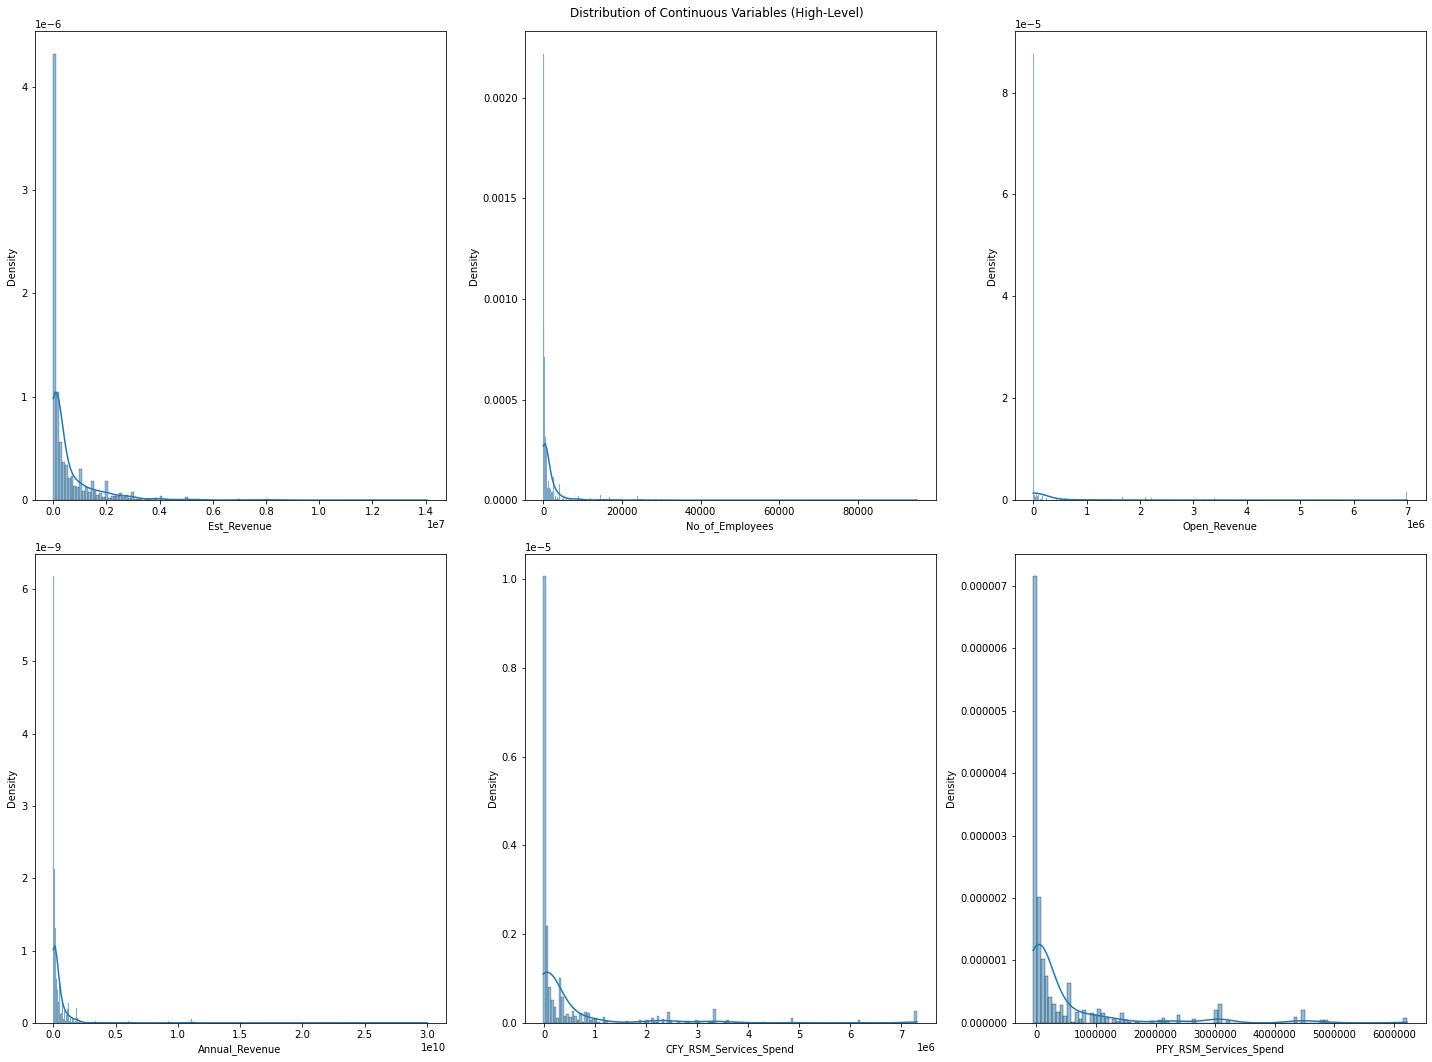

In [33]:
"""plot high-level view of distribution of key continuous predictors"""
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
sns.histplot(opp_numeric, x='Est_Revenue', stat='density', kde=True, ax=ax[0,0])
sns.histplot(opp_numeric, x='No_of_Employees', stat='density', kde=True, ax=ax[0, 1])
sns.histplot(opp_numeric, x='Open_Revenue', stat='density', kde=True, ax=ax[0, 2])
sns.histplot(opp_numeric, x='Annual_Revenue', stat='density', kde=True, ax=ax[1,0])
sns.histplot(opp_numeric, x='CFY_RSM_Services_Spend', stat='density', kde=True, ax=ax[1, 1])
sns.histplot(opp_numeric, x='PFY_RSM_Services_Spend', stat='density', kde=True, ax=ax[1, 2])
plt.ticklabel_format(style='Plain')
fig.suptitle('Distribution of Continuous Variables (High-Level)')
plt.tight_layout()

## *Explore Relationship Between Variables*

### Methods

- Pearson's Correlation
- Distribution Plots

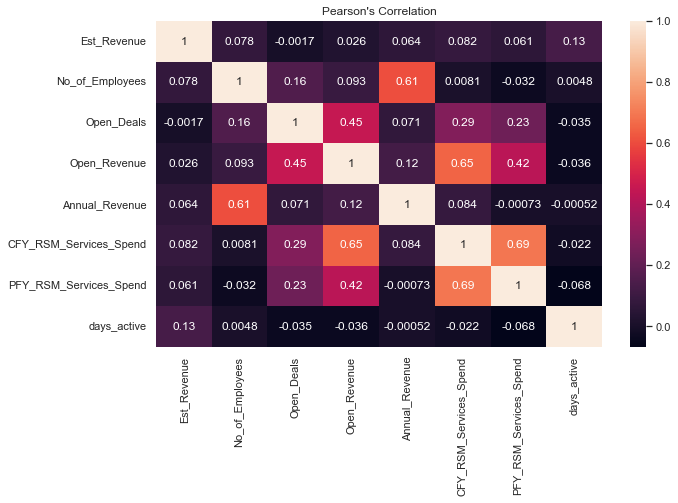

In [34]:
# plot correlation of numeric data
sns.set(rc={"figure.figsize":(10, 6)})
opp_numeric_corr = opp_numeric.fillna(value=0)
correlation = sns.heatmap(opp_numeric_corr.corr(), cmap='rocket',
                          annot=True).set_title('Pearson\'s Correlation')

## *_Feature Selection_*

- Combine data
- Perform univariate feature selection using Mutual Information Criteria

In [35]:
"""recombine data"""
# join continuous and categorical features on indices
opportunities = pd.merge(opp_numeric, opp_non_numeric, left_index=True, right_index=True, how='inner')
opportunities = pd.merge(opportunities, opp_geographic, left_index=True, right_index=True, how='inner')
# move outcome "Won" to last column idx of dataframe
cols = opportunities.columns.values.tolist()
cols.insert(len(cols), cols.pop(cols.index('Won')))
opportunities = opportunities[cols]

In [36]:
"""preprocessing"""

# drop columns that will not be included in final model
opportunities.drop(columns=['Est_Close_Date', 'System_Close_Date', 'Created_On','Latitude', 
                            'Longitude', 'City', 'County', 'ZIP_Postal_Code' ], inplace=True)
# susbset features for mutual infomation feature selection
x = opportunities.iloc[:, :-1]
y = opportunities.iloc[:, -1]
# index continuous and categorical features
numeric_idx = x.select_dtypes(include=['int64', 'float64']).columns
categorical_idx = x.select_dtypes(include=['object', 'bool']).columns
# encode categorical features as integers
oe = OrdinalEncoder()
oe.fit(x[categorical_idx])
# apply robust scaling to continuous features
x[categorical_idx] = oe.transform(x[categorical_idx])
numeric_scaler = RobustScaler()
x[numeric_idx] = numeric_scaler.fit_transform(x[numeric_idx])


In [37]:
"""define Mutual Info classifier"""

# get indices for categorical features
discrete_idx =[]
for col in categorical_idx:
   discrete_idx.append(x.columns.get_loc(col))
# fit mutual_info_class passing the indices of discrete columns as param
importance = mutual_info_classif(x, y, random_state=14, discrete_features=discrete_idx)
importance = pd.Series(importance, index=x.columns)
importance.sort_values(ascending=False, inplace=True)

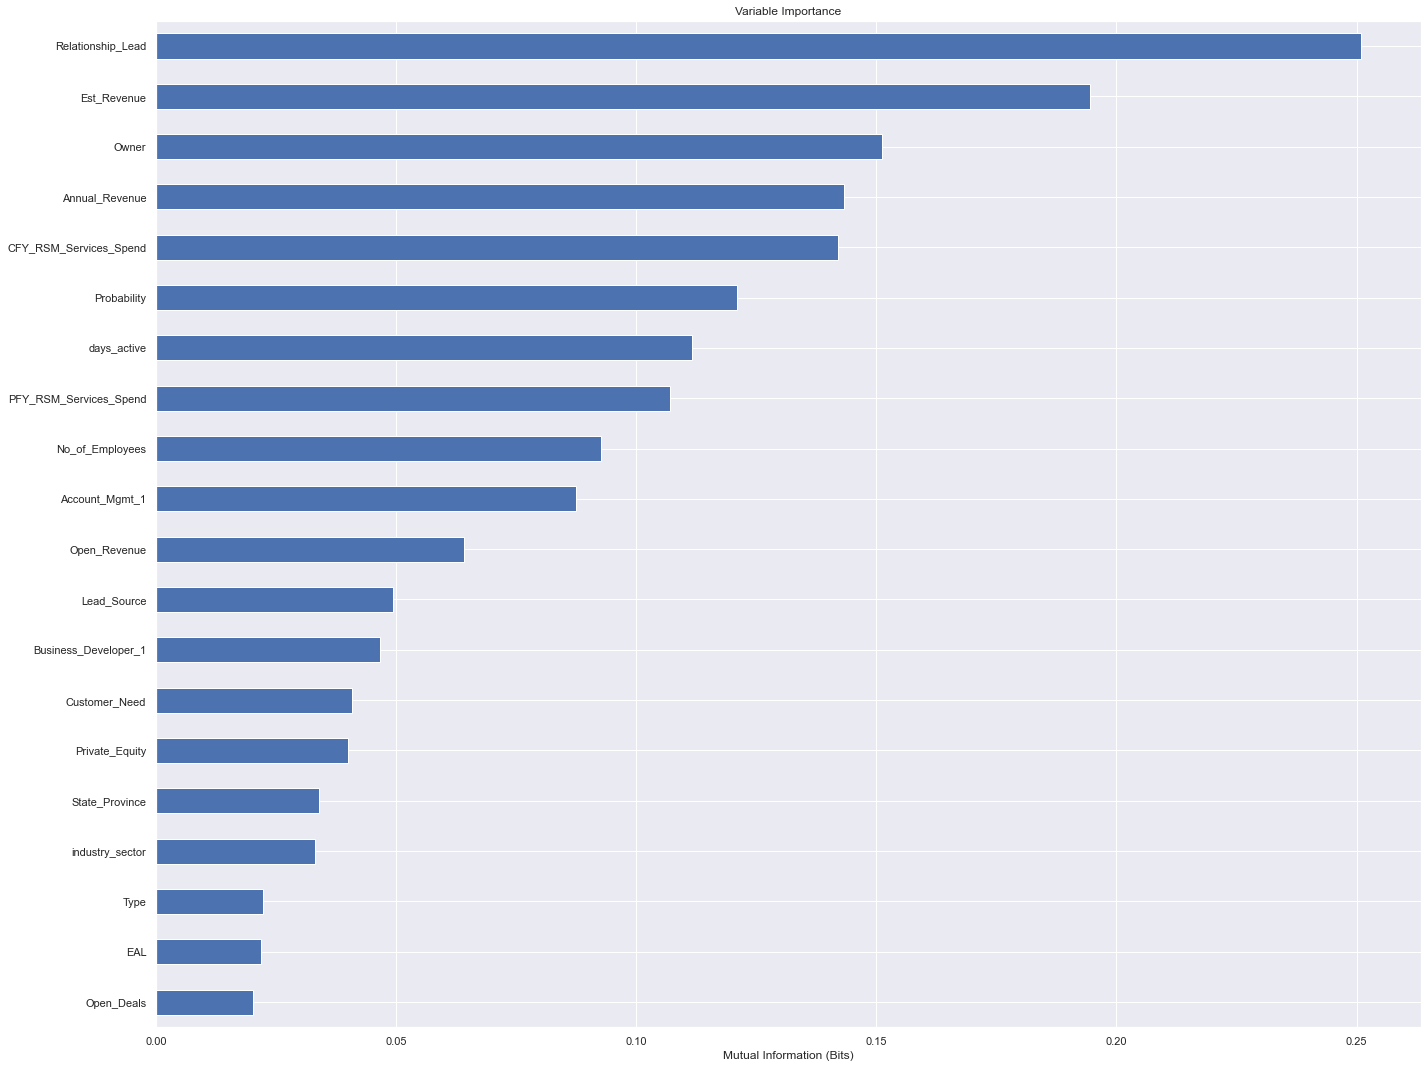

In [38]:
"""Plot variable importance"""
importance[0:20].sort_values(ascending=True).plot.barh(figsize=(20, 15))
plt.title('Variable Importance')
plt.xlabel('Mutual Information (Bits)')
plt.tight_layout()

## *_Model Selection_*

- Light Gradient Boosted Machine (lgbm)
- Extreme Gradient Boosting (xgboost)
- Catboost

In [39]:
"""preprocessing"""
# subset top 20 features for lgbm and xgboost
x = opportunities[importance[0:20].index].copy()
y = opportunities.iloc[:, -1].copy()
# create index of continuous and categorical features
numeric_idx = x.select_dtypes(include=['int64', 'float64']).columns
categorical_idx = x.select_dtypes(include=['object', 'bool']).columns
# apply one hot encoding and robust scaler to the lgm and xgboost data
x[categorical_idx] = x[categorical_idx].astype('category')
x = pd.get_dummies(x, drop_first=True)
numeric_scaler = RobustScaler()
x[numeric_idx] = numeric_scaler.fit_transform(x[numeric_idx])
# lightgbm does not support existence of JSON special characters in feature names
x = x.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# subset top 20 features for catboost
# catboost does not require one-hot encoding of categorical predictors
x_catboost = opportunities[importance[0:20].index].copy()
y_catboost = opportunities.iloc[:, -1].copy()
x_catboost[categorical_idx] = x_catboost[categorical_idx].astype('category')
x_catboost_categorical_idx = categorical_idx.values
x_catboost[numeric_idx] = numeric_scaler.fit_transform(x_catboost[numeric_idx])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(x_catboost, y,
                                                                    test_size=0.30,
                                                                    random_state=1)

In [40]:
"""utility function to print classification_report for models"""
def print_report(y_test, predictions):
    target_names = ['Lost', 'Won']
    # sklearn classification report function
    print(classification_report(y_test, predictions, target_names=target_names))

In [41]:
"""utility function to plot feature importance for models"""

def plot_importance(feature_names, feature_importance, model_type, importance_metric):

    #Create a DataFrame of results
    model_results = {'feature_names':feature_names,'feature_importance':feature_importance}
    model_results = pd.DataFrame(model_results)
    # sort results by decreasing feature importance
    model_results.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    # specify plot size
    plt.figure(figsize=(15,8))
    # create the plot
    sns.barplot(x=model_results['feature_importance'], y=model_results['feature_names'])
    # add labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel(importance_metric)
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [42]:
"""really light gbm"""
# intantiate and fit the model
lgbm_model = LGBMClassifier()
lgbm_model.fit(x_train, y_train)
# make prediction and print report
predictions = lgbm_model.predict(x_test)
print_report(y_test, predictions)

              precision    recall  f1-score   support

        Lost       0.82      0.84      0.82       285
         Won       0.82      0.80      0.81       275

    accuracy                           0.82       560
   macro avg       0.82      0.82      0.82       560
weighted avg       0.82      0.82      0.82       560



In [ ]:
"""simple XGBoost"""
# instantiate and fit the model
xgboost_model = XGBClassifier()
xgboost_model.fit(x_train, y_train)
# make predictions and print report
predictions = xgboost_model.predict(x_test)
print_report(y_test, predictions)

In [43]:
"""simple catboost"""
# instantiate the model
catboost_model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent'
)
# fit the model and print report
catboost_model.fit(
    x_train_cat, y_train_cat,
    cat_features=x_catboost_categorical_idx,
    eval_set=(x_test_cat, y_test_cat),
     #logging_level='Verbose',  # you can uncomment this for text output
    plot=True
)
predictions = catboost_model.predict(x_test_cat)
print_report(y_test_cat, predictions)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

        Lost       0.84      0.85      0.84       285
         Won       0.84      0.83      0.84       275

    accuracy                           0.84       560
   macro avg       0.84      0.84      0.84       560
weighted avg       0.84      0.84      0.84       560



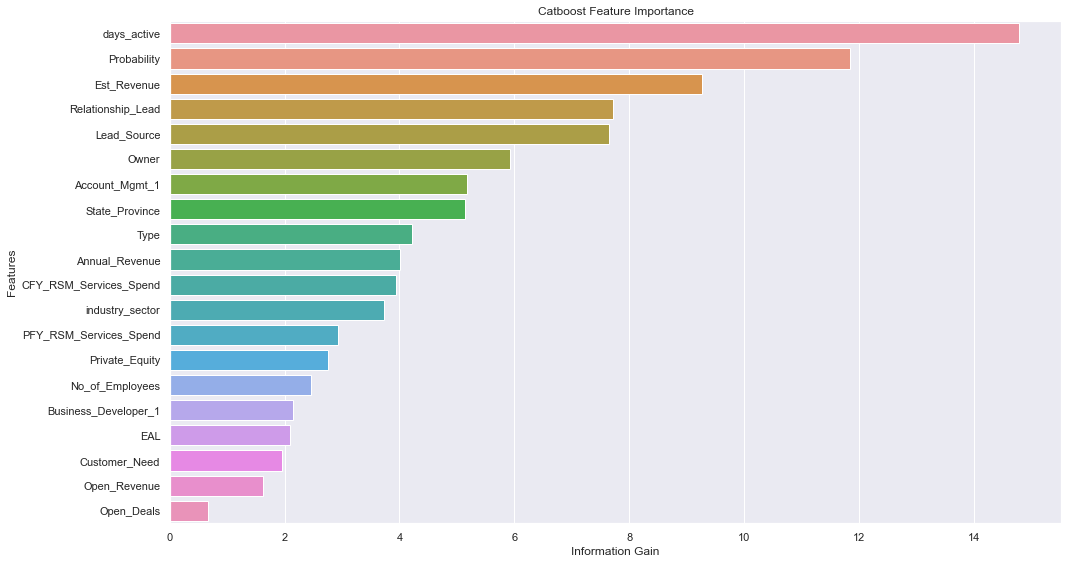

In [44]:
"""plot feature importance"""
plot_importance(x_test_cat.columns, catboost_model.get_feature_importance(), "Catboost", "Information Gain")